In [1]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..',
                                       'evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/'))
assert os.path.isdir(maindir)

# THIS ASSUMES YOU ALREADY CREATED THE EVALUATIIN AGGREGATION. SEE AGGREGAT.EVALUATIONS
path = os.path.join(maindir, 'evaluation.all.hdf')


dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

allset_test = sod_core_dataset.allset_test

# define the classes of interest (see sod code allset_test)
class_inlier = allset_test.classnames[0] # 'ok' 
class_outlier = allset_test.classnames[1] #'outl. (wrong inv)'
class_me_unknown = allset_test.classnames[2]  # 'unlabeled (Me unknown)'

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]

evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (wrong inv)' 'unlabeled (Me unknown)']


In [2]:
print('Loading only one classifier bet_outl_t50')

print()
print('Some estimations on time performances')
from itertools import product
ref = 50*np.log(512)
for t, psi in product([50, 100, 200], [512, 2048, 8192]):
    print('t=%f,psi=%f: %.1f time longer' % (t, psi, t*np.log(psi)/ref))

import pandas as pd

# adding the two best with two features, with contamination 5% an 10%
fnames = {
    #'best_avg_t50': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    # 'best_avg': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
    # 'best_out_same_t_psi': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    # 'best_inl_same_t_psi': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    # 'best_inl_t50': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
    'best_outl_t50': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
    # 'best_outl': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
}

print()
print('Loading models and predictions')
rootdir = maindir.replace('evalreports', '')
clfs = {k: load(os.path.join(rootdir, 'models', v + '.model')) for k, v in fnames.items()}
pred_dfs = {k: pd.read_hdf(os.path.join(rootdir, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

clf = list(clfs.values())[0]
pred_df = list(pred_dfs.values())[0]

# print('loading source trainset')
# dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

Loading only one classifier bet_outl_t50

Some estimations on time performances
t=50.000000,psi=512.000000: 1.0 time longer
t=50.000000,psi=2048.000000: 1.2 time longer
t=50.000000,psi=8192.000000: 1.4 time longer
t=100.000000,psi=512.000000: 2.0 time longer
t=100.000000,psi=2048.000000: 2.4 time longer
t=100.000000,psi=8192.000000: 2.9 time longer
t=200.000000,psi=512.000000: 4.0 time longer
t=200.000000,psi=2048.000000: 4.9 time longer
t=200.000000,psi=8192.000000: 5.8 time longer

Loading models and predictions
best_outl_t50: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=512, n_estimators=50, n_jobs=None,
                random_state=None, verbose=0, warm_start=False)


In [3]:
# let's try to see the max score

arr = np.array([[-10.0**_] for _ in np.arange(-20, 20)])
print(-clfs['best_outl_t50'].score_samples(arr))

arr = np.array([[-125+ (_/10.0)] for _ in np.arange(20)])
# print(arr)
print(-clfs['best_outl_t50'].score_samples(arr))


# offsets defined as the threshold at which we have the best average accuracy (previous notebook)

offsets = {
    'best_avg_t50': -0.029947821583554912,
    'best_avg': -0.029995885632446373,
    'best_inl_t50': 0.010002543367576111,
    'best_outl_t50': -0.06896680076768469,
    'best_outl': -0.049863431538516134
}

clf_offset = offsets['best_outl_t50']

print('LOADING TRAINING SET')
# let's see to which percentile corresponds the offset 0.06
# scikit learn converts -score_sample+np.percentile(score_samples(training))
trainset = sod_core_dataset.open_dataset('allset_train', normalize=False)

[0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.55503867 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304]
[0.41849879 0.41572067 0.41502936 0.41626825 0.4161144  0.41189393
 0.41030571 0.41307557 0.4142254  0.42078642 0.41521812 0.42041246
 0.42049516 0.41754393 0.42105658 0.42111694 0.42189423 0.41921668
 0.42559505 0.42415504]
LOADING TRAINING SET
Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf


ok (1295742 instances)
                          Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -1.982674e+02 -121.027945    -18.616519  524709      7711       7711
psd@0.1sec      -2.0

In [35]:
# we have an offset of 0.56896. To which scikit contamination corresponds? Roughly 0.05
traindata = trainset['psd@5sec'].dropna()
trainscores = -clf.score_samples(traindata.values.reshape(len(traindata), 1))
print('triainscores: min: %f, max: %f' % (trainscores.min(), trainscores.max()))
for th in np.arange(0, 0.15, 0.001):
    print('Threshold %f, scikit offset_=%f' % (th, np.percentile(trainscores, 100*th)))

triainscores: min: 0.406816, max: 0.815615
Threshold 0.000000, scikit offset_=0.406816
Threshold 0.001000, scikit offset_=0.409086
Threshold 0.002000, scikit offset_=0.409086
Threshold 0.003000, scikit offset_=0.409219
Threshold 0.004000, scikit offset_=0.409902
Threshold 0.005000, scikit offset_=0.410306
Threshold 0.006000, scikit offset_=0.410306
Threshold 0.007000, scikit offset_=0.411760
Threshold 0.008000, scikit offset_=0.411894
Threshold 0.009000, scikit offset_=0.412141
Threshold 0.010000, scikit offset_=0.412520
Threshold 0.011000, scikit offset_=0.413059
Threshold 0.012000, scikit offset_=0.413076
Threshold 0.013000, scikit offset_=0.413177
Threshold 0.014000, scikit offset_=0.413496
Threshold 0.015000, scikit offset_=0.414225
Threshold 0.016000, scikit offset_=0.414246
Threshold 0.017000, scikit offset_=0.414288
Threshold 0.018000, scikit offset_=0.414288
Threshold 0.019000, scikit offset_=0.414364
Threshold 0.020000, scikit offset_=0.414608
Threshold 0.021000, scikit offset

In [36]:
from sklearn.metrics import log_loss, roc_curve
from sklearn.linear_model import LogisticRegression
import numpy as np

def logistic_r(scores, c=0.001):
    
    name = 'best_outl_t50'
    pred_df = pred_dfs[name]
    prd_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)]

    size = len(prd_df)
    X = prd_df.predicted_anomaly_score.values.reshape(size, 1)
    y = prd_df.outlier.values
    
    lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=c).fit(X, y)
    scores = lr_clf.predict_proba(scores.reshape(len(scores),1))[:,1]
    return scores

logistic_r(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

array([0.05042124, 0.08906609, 0.15257094, 0.24897934, 0.37905786,
       0.529208  , 0.6742519 , 0.7921598 , 0.87528384, 0.92817729])

training scores, min: 0.337849, max: 0.746648


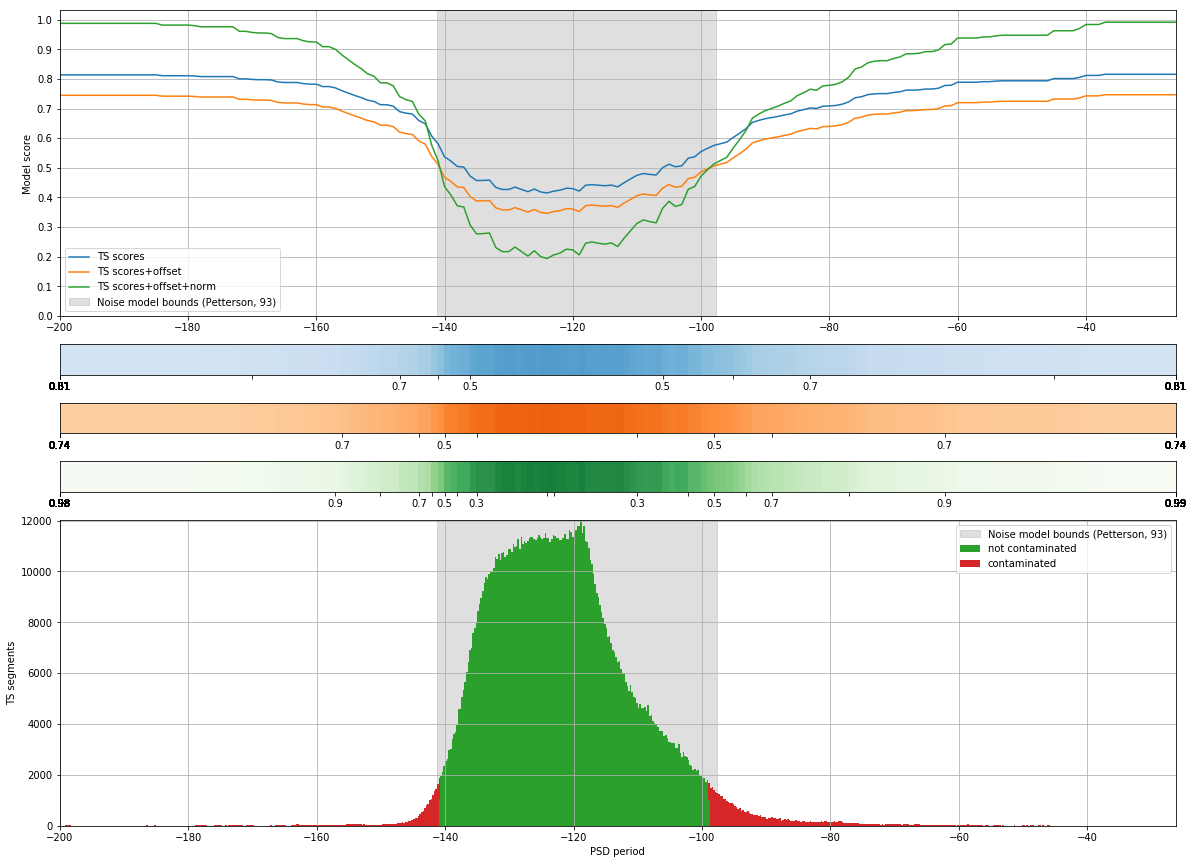

In [175]:
import matplotlib.pyplot as plt


min_, max_ = np.nanmin(trainscores), np.nanmax(trainscores)  # TO BE CALCULATED CORRECTLY
min_o = min_ + clf_offset
max_o = max_ + clf_offset
print('training scores, min: %f, max: %f' % (min_o, max_o))
# min is closer to 0.5, if we want to preserve 0.5 we have to stretch the shorter half:
ratio = 0.5 / min_
# calibration using logregr:
#lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X, y)
#scores = lr_clf.predict_proba(X)[:,1]

from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 


clf_offset= -0.06896680076768469
max_score = 0.82  # 0.8156149673841953


def normalize(scores, offset=clf_offset, max_score=max_score):
    max_score += offset
    # we map any score between 0. 5 and max_ to a score between 0.5 and 1:
    # I.e., we normalize outliers and we normalize everything else as it is
    scores += offset
    ret = 0.5 + 0.5*(scores-0.5)/(max_score-0.5)
    return ret

bins = np.arange(-200, -25, 1)

fig, axes = plt.subplots(5, figsize=(20, 15), gridspec_kw={'height_ratios': [10, 1, 1, 1, 10]})

bin_scores = -clf.score_samples(bins.reshape(len(bins), 1))
data = {
    'TS scores': [bin_scores, 'tab:blue', 'Blues_r'],
    'TS scores+offset': [bin_scores+clf_offset, 'tab:orange', 'Oranges_r'],
    'TS scores+offset+norm': [normalize(np.copy(bin_scores)), 'tab:green', 'Greens_r'],
}

ax = axes[0]
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray', label='Noise model bounds (Petterson, 93)')
for name, (y, color, cmap) in data.items():
    ax.plot(bins, y, label=name)
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.set_ylabel('Model score')
ax.get_yaxis().set_ticks(np.arange(0, 1.05, 0.1))
ax.grid()


# xlims = axes[1].get_xlim()
axes_i = 1
for name, (y, color, cmap) in data.items():
    c=axes[axes_i].pcolor(bins, [0, 1], y.reshape(1, len(y)), cmap=cmap, vmin=0, vmax=1)
    axes[axes_i].get_yaxis().set_ticks([])
    axes[axes_i].set_xlim([bins[0], bins[-1]])
    xticks = []
    xticks_l = []
    # build demarcation lines on the plot for each decimal increase (see scores_bins)
    # there's surely a faster method thatn this loop, but did not find quickly:
    for i, (prev_v, next_v) in enumerate(zip(y[:-1], y[1:]), 1):
        prev_v, next_v = int(10*prev_v), int(10*next_v) 
        if prev_v != next_v:
            # axes[axes_i].axvline(bins[i], color=color)
            xticks.append(bins[i])
            val = prev_v if next_v < prev_v else next_v
            # display the score as tick label only if odd (not much space on the x axis)
            val = str(val/10) if val % 2 == 1 else ''
            xticks_l.append(val)
        xticks.insert(0, bins[0])
        xticks_l.insert(0, str(int(100*y[0])/100.0))
        xticks.append(bins[-1])
        xticks_l.append(str(int(100*y[-1])/100.0))
        
    axes[axes_i].set_xticks(xticks)
    axes[axes_i].set_xticklabels(xticks_l)
    # axes[axes_i].set_title(name)
    axes_i += 1


contaminated = trainscores > 0.5 - clf_offset
assert contaminated.any()
data =[
    traindata[~contaminated],
    traindata[contaminated]
]
label =[
    'not contaminated',
    'contaminated'
]
bins = np.arange(bins[0], bins[-1], .25)
ax = axes[-1]
ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray', label='Noise model bounds (Petterson, 93)')
ax.hist(data, bins, label=label, log=False, stacked=True, color=['tab:green', 'tab:red'])
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
ax.grid()
ax.set_xlabel('PSD period')
ax.set_ylabel('TS segments')
    
# print(max_)
# print(normalize(max_))
# print(clf_offset)
plt.show()

In [ ]:
from sklearn.metrics import log_loss, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline

def plot_sep_th(outliers, scores):
    fpr, tpr, th = roc_curve(outliers, scores)
    bestscores = 0.5*((1-fpr[1:]) + tpr[1:])
    argmax = np.argmax(bestscores[1:])
    plt.plot(th[1:], bestscores)
    plt.title(th[argmax+1])
    plt.scatter(th[argmax+1], bestscores[argmax+1])
    plt.grid()
    plt.show()
    

name = 'best_outl_t50'
pred_df = pred_dfs[name]

# pred_df.predicted_anomaly_score -= 0.06

prd_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)]

size = len(prd_df)
X = prd_df.predicted_anomaly_score.values.reshape(size, 1)
y = prd_df.outlier.values

print('Normal clf')
plot_sep_th(y, prd_df.predicted_anomaly_score.values)

offset = -0.0766
print('Normal clf with offset %f' % offset)
plot_sep_th(y, prd_df.predicted_anomaly_score.values + offset)


print('Normal clf with offset %f and linear normalization' % offset)
min_, max_ = 0.4, 0.82  # see above
min_ += offset
max_ += offset
scores = (prd_df.predicted_anomaly_score.values + offset - min_)/(max_ - min_)
plot_sep_th(y, scores)
plt.scatter(prd_df.predicted_anomaly_score.values, scores)
plt.xlabel('score')
plt.ylabel('calibrated score')
plt.grid()
#plt.xlim([0.4, 0.8])
#plt.ylim([0, 1])
plt.show()


for C in [0.001,0.002,0.003,0.004,0.005, 0.01, 0.04, 0.05]:
    lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X, y)
    scores = lr_clf.predict_proba(X)[:,1]
    logloss = log_loss(prd_df.outlier, scores, labels=[False, True])
    diffs = prd_df.predicted_anomaly_score.values - scores

    fpr, tpr, th = roc_curve(prd_df.outlier, scores)
    
    print(
        name +
        ' sigmoid calibrated C=%f, log loss: %f' % (C, logloss)
    )
    argmax = np.argmax(np.abs(diffs))
    print('Max diff: %f: predicted score %f becomes (calibrated): %f ' %
          (diffs[argmax], prd_df.predicted_anomaly_score.values[argmax], scores[argmax]))
    plot_sep_th(y, scores)
    plt.scatter(prd_df.predicted_anomaly_score.values, scores)
    plt.xlabel('score')
    plt.ylabel('calibrated score')
    plt.xlim([0.4, 0.8])
    plt.ylim([0, 1])
    plt.grid()
    # plt.scatter([prd_df.predicted_anomaly_score.values, scores], label=['scores', 'calib.scores'])
    plt.show()
    print()

[0.99328215 0.99526665 0.99526665 ... 0.52325581 0.03359506 0.02076309]

best_outl_t50 normal 0.4065720966460681


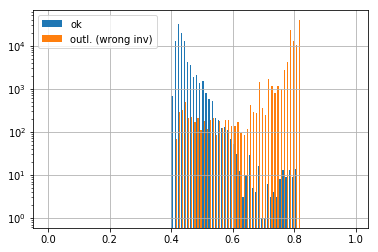

best_outl_t50 with offset 0.401044728829386


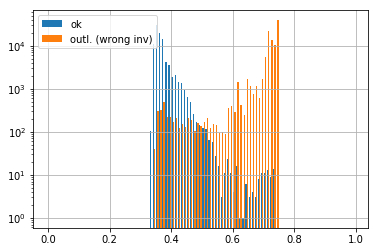

best_outl_t50 sigmoid calibrated 0.1651555384553489


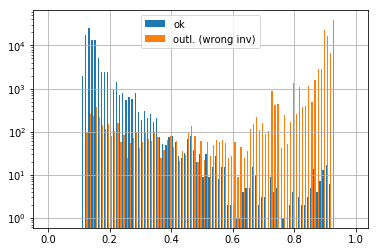

best_outl_t50 isotonic 0.06611902958119015


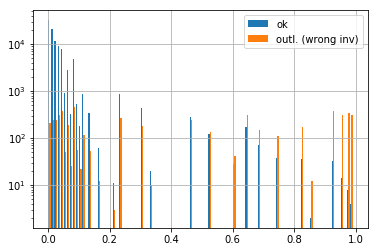

In [8]:
from sklearn.metrics import log_loss, roc_curve

from sklearn.linear_model import LogisticRegression
name = 'best_outl_t50'
pred_df = pred_dfs[name]
prd_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)]

size = len(prd_df)
X = prd_df.predicted_anomaly_score.values.reshape(size, 1)
y = prd_df.outlier.values
    
lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=0.004).fit(X, y)
# print(lr_clf.predict_proba(X)[:,1])
# print(y)


def logloss(listofdata):
    _ = pd.concat(data, sort=False, axis=0)
    return log_loss(_.outlier, _.predicted)

from sklearn.isotonic import IsotonicRegression as IR

ir = IR( out_of_bounds = 'clip')
ir.fit( prd_df.predicted_anomaly_score.values, y)
ir_calibrated = ir.transform(prd_df.predicted_anomaly_score.values)
print(ir_calibrated)

bins = np.arange(0,1,0.01)
log_ = True
print()

    
scores = prd_df.predicted_anomaly_score
logloss = log_loss(prd_df.outlier, scores, labels=[False, True])
print(name + ' normal ' + str(logloss))
data = [
    pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
    pred_df[sel_outlier(pred_df)].predicted_anomaly_score
]
plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
plt.grid()
# plt.ylim([1, 40000]) #  10**5])
plt.legend()
plt.show()

scores = prd_df.predicted_anomaly_score + offsets[name]
logloss = log_loss(prd_df.outlier, scores, labels=[False, True])
print(name + ' with offset ' + str(logloss))
data = [
    pred_df[sel_inlier(pred_df)].predicted_anomaly_score + offsets[name],
    pred_df[sel_outlier(pred_df)].predicted_anomaly_score + offsets[name]
]
plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
plt.grid()
# plt.ylim([1, 40000]) #  10**5])
plt.legend()
plt.show()

scores = lr_clf.predict_proba(X)[:,1]
logloss = log_loss(prd_df.outlier, scores, labels=[False, True])
print(name + ' sigmoid calibrated ' + str(logloss))
data = [
    lr_clf.predict_proba(X)[:,1][~y],
    lr_clf.predict_proba(X)[:,1][y]
]
plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
plt.grid()
# plt.ylim([1, 40000]) #  10**5])
plt.legend()
plt.show()

scores = ir_calibrated
logloss = log_loss(prd_df.outlier, scores, labels=[False, True])
print(name + ' isotonic ' + str(logloss))
data = [
    ir_calibrated[~y],
    ir_calibrated[y]
]
plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
plt.grid()
# plt.ylim([1, 40000]) #  10**5])
plt.legend()
plt.show()

In [ ]:
# fare un boxplot asse x: tempo, asse y: score_samples